In [2]:
import numpy as np # 행렬,벡터,수치 연산
import matplotlib.pyplot as plt # 시각화

import torch # 파이토치
import torch.nn as nn # 파이토치 모듈(레이어, 손실 함수 포함)
import torch.nn.init as init # 초기화 관련 모듈 
import torch.optim as optim #최적화함수; 파라미터 업데이트
from torch.utils.data import DataLoader # 데이터셋을 학습에 용이하게 바꿈; 데이터셋을 미니배치로 바꿔줌
import torch.nn.functional as F # 자주 쓰는 함수를 F로 따로 가져옴

import torchvision # 이미지 처리하는 파이토치
from torchvision import transforms, datasets # 미이지 전처리에 사용 / MNIST dataset 불러옴

#하이퍼파라미터 설정
batch_size = 32  # 한 번 학습할 때 사용하는 데이터의 샘플 수
learning_rate = 0.01  # 모델이 파라미터를 얼마나 빠르게 업데이트할지 조절하는 값
num_epoch = 10  # 전체 데이터셋을 몇 번 반복해서 학습할지 설정

In [3]:
train_dataset = datasets.MNIST(
	"./", # 경로 지정 - 현재 코드가 위치한 경로로
	train=True, # train set이니까 True
	transform=transforms.ToTensor(), # 이미지 데이터를 텐서 형태로 변환해줌. 각 픽셀을 0~1 사이로 regularization
	target_transform=None, # label에 대해 변형
	download=True
)

test_dataset = datasets.MNIST(
    root="./",
    train=False, # test set이니까 False
    download=True,
    transform=transforms.ToTensor() 
)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


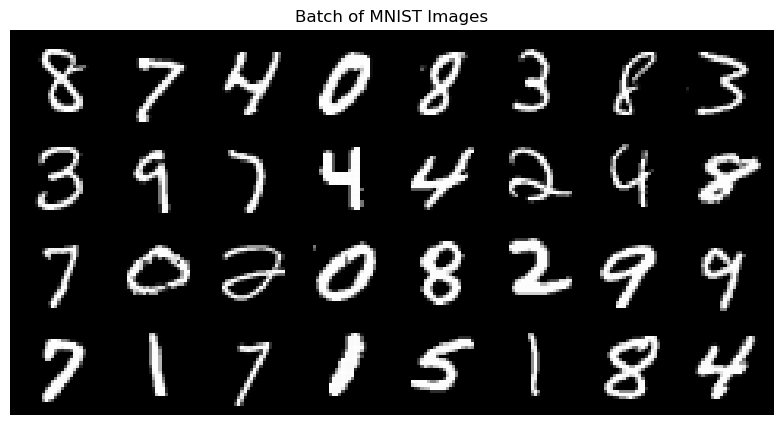

In [6]:
for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break
images, labels = next(iter(train_loader))

grid_img = torchvision.utils.make_grid(images, nrow=8, padding=2, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title("Batch of MNIST Images")
plt.show()

In [7]:
class MLP(nn.Module): # 메타클래스 nn.Module 상속받아 MLP 클래스 생성 (몰라도됨)
	def __init__(self): 
		super(MLP, self).__init__()
		
	
	
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # layer 생성
        self.fc1 = nn.Linear(28 * 28, 512) # input 값은 픽셀 수만큼 28 * 28
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10) # 0~9 값에 대한 확률을 뱉어야하니까 output은 10
        
        self.dropout = nn.Dropout(0.5) # 연산마다 50% 비율로 랜덤하게 노드 삭제... 나중에
        
        self.batch_norm1 = nn.BatchNorm1d(512) # 1dimension이기 때문에 BatchNorm1d를 사용함.
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x): # 모델의 연산 순서를 정의
    # 1st layer
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # activation function
        x = self.dropout(x)
    # 2nd layer
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)
    # 3rd layer
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # 출력값은 softmax
        return x

In [8]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model= MLP()
model.apply(weight_init)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [9]:
def train(model, train_loader, optimizer):
    model.train() # 모델 상태를 '학습중'으로 변경
    for batch_idx, (image, label) in enumerate(train_loader): # X, y로 이루어진 train set
        optimizer.zero_grad() # 최적화 초기화
        output = model(image) #  모델에 input을 넣어서 예측값을 구한다
        loss = loss_fn(output, label) # 손실함수, error 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정
        optimizer.step() # 역전파 진행 및 가중치 업데이트

In [10]:
def evaluate(model, test_loader):
    model.eval() # 모델 상태를 '평가중' 으로 변경
    test_loss = 0
    correct = 0

    with torch.no_grad(): # 모델의 평가 단계이므로 gradient가 업데이트 되지 않도록 함
        for image, label in test_loader:
            output = model(image)
            test_loss += loss_fn(output, label).item() # loss 누적
            prediction = output.max(1, keepdim=True)[1] # 가장 확률이 큰 값으로 output 반환
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 예측 몇개 맞음?
    
    test_loss /= len(test_loader.dataset) # loss 평균값 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) # 예측 정확도 계산
    return test_loss, test_accuracy

In [11]:
# 결과를 저장할 리스트
epoch_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(1, num_epoch + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    epoch_list.append(epoch)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    
    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %".format(
        epoch, test_loss, test_accuracy
    ))

[EPOCH: 1], 	Test Loss: 0.0040, 	Test Accuracy: 96.07 %
[EPOCH: 2], 	Test Loss: 0.0032, 	Test Accuracy: 96.66 %
[EPOCH: 3], 	Test Loss: 0.0030, 	Test Accuracy: 96.84 %
[EPOCH: 4], 	Test Loss: 0.0027, 	Test Accuracy: 97.50 %
[EPOCH: 5], 	Test Loss: 0.0024, 	Test Accuracy: 97.58 %
[EPOCH: 6], 	Test Loss: 0.0026, 	Test Accuracy: 97.42 %
[EPOCH: 7], 	Test Loss: 0.0024, 	Test Accuracy: 97.72 %
[EPOCH: 8], 	Test Loss: 0.0023, 	Test Accuracy: 97.81 %
[EPOCH: 9], 	Test Loss: 0.0021, 	Test Accuracy: 97.93 %
[EPOCH: 10], 	Test Loss: 0.0020, 	Test Accuracy: 98.05 %


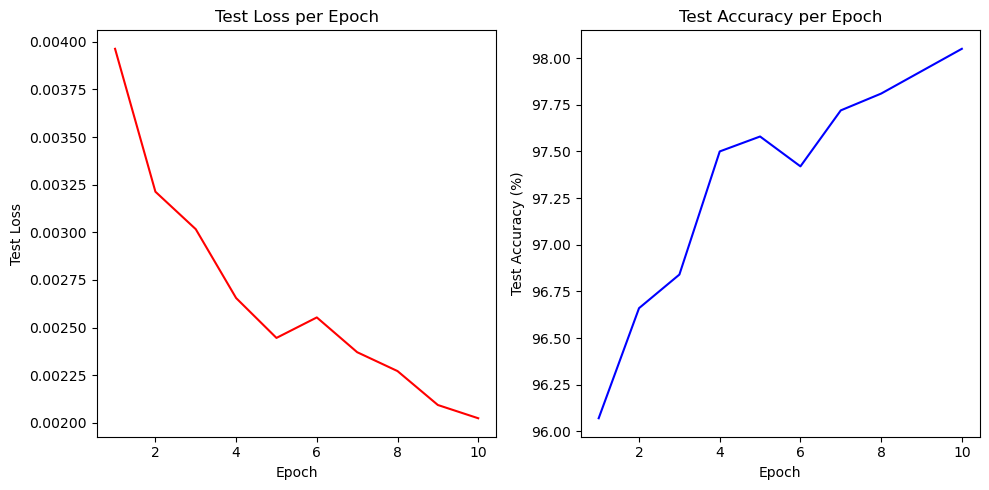

In [12]:
# 시각화
plt.figure(figsize=(10, 5))

# Test Loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, test_loss_list, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch')

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy per Epoch')

plt.tight_layout()
plt.show()